In [1]:
# import utils and basic libraries
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from utils.preprocessing import gen_sub, bicubic
from utils.loss import l1_loss, psnr, ssim
from utils.network import Super3D
from utils.training import Trainer
from skimage import io
from zipfile import ZipFile

/Users/shubham/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/shubham/Library/Python/3.9/lib/python/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  war

In [2]:
#-------------
# General Settings
#-------------
PATH_DATASET = 'dataset' # pre-processed dataset path
name_net = 'Super3D' # name of the network
LR_SIZE = 32 # pathces dimension
SCALE = 3 # upscale of the proba-v dataset is 3
HR_SIZE = LR_SIZE * SCALE # upscale of the dataset is 3
OVERLAP = 32 # overlap between pathces
CLEAN_PATH_PX = 0.85 # percentage of clean pixels to accept a patch
band = 'NIR' # choose the band for the training
checkpoint_dir = f'ckpt/{band}_{name_net}_retrain' # weights path
log_dir = 'logs' # tensorboard logs path
submission_dir = 'submission' # submission dir

In [3]:
#-------------
# Network Settings
#-------------
FILTERS = 32 # features map in the network
KERNEL_SIZE = 3 # convolutional kernel size dimension (either 3D and 2D)
CHANNELS = 9 # number of temporal steps
R = 8 # attention compression
N = 12 # number of residual feature attention blocks
lr = 1e-4 # learning rate (Nadam optimizer)
BATCH_SIZE = 14 # batch size
EPOCHS_N = 50 # number of epochs

In [4]:
# create logs folder
if not os.path.exists(log_dir):
    os.mkdir(log_dir)

<a id="loading"></a>
# 1.0 Dataset loading

In [6]:
# load training dataset
X_train = np.load(os.path.join(PATH_DATASET, f'X_{band}_train.npy'))
y_train = np.load(os.path.join(PATH_DATASET, f'y_{band}_train.npy'))
y_train_mask = np.load(os.path.join(PATH_DATASET, f'y_{band}_train_masks.npy'))

In [7]:
# load validation dataset
X_val = np.load(os.path.join(PATH_DATASET, f'X_{band}_val.npy'))
y_val = np.load(os.path.join(PATH_DATASET, f'y_{band}_val.npy'))
y_val_mask = np.load(os.path.join(PATH_DATASET, f'y_{band}_val_masks.npy'))

In [8]:
# print loaded dataset info
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('y_train_mask: ', y_train_mask.shape)


print('X_val: ', X_val.shape)
print('y_val: ', y_val.shape)
print('y_val_mask: ', y_val_mask.shape)

X_train:  (343, 128, 128, 9)
y_train:  (343, 384, 384, 1)
y_train_mask:  (343, 384, 384, 1)
X_val:  (20, 128, 128, 9)
y_val:  (20, 384, 384, 1)
y_val_mask:  (20, 384, 384, 1)


<a id="preprocessing"></a>
# 2.0 Dataset Pre-Processing

## 2.1 Make patches

In [9]:
# create patches for LR images
d = LR_SIZE  # 32x32 patches
s = OVERLAP  # overlapping patches
# Ex: n = (128-d)/s+1 = 7 -> 49 sub images from each image

X_train_patches = gen_sub(X_train,d,s)
X_val_patches = gen_sub(X_val,d,s)

Creating sub images:   0%|          | 0/343 [00:00<?, ?it/s]

(5488, 32, 32, 9)


Creating sub images:   0%|          | 0/20 [00:00<?, ?it/s]

(320, 32, 32, 9)


In [10]:
# create patches for HR images and masks
d = HR_SIZE  # 96x96 patches
s = OVERLAP * SCALE  # overlapping patches
# Ex: n = (384-d)/s+1 = 7 -> 49 sub images from each image

y_train_patches = gen_sub(y_train,d,s)
y_train_mask_patches = gen_sub(y_train_mask,d,s)


y_val_patches = gen_sub(y_val,d,s)
y_val_mask_patches = gen_sub(y_val_mask,d,s)

Creating sub images:   0%|          | 0/343 [00:00<?, ?it/s]

(5488, 96, 96, 1)


Creating sub images:   0%|          | 0/343 [00:00<?, ?it/s]

(5488, 96, 96, 1)


Creating sub images:   0%|          | 0/20 [00:00<?, ?it/s]

(320, 96, 96, 1)


Creating sub images:   0%|          | 0/20 [00:00<?, ?it/s]

(320, 96, 96, 1)


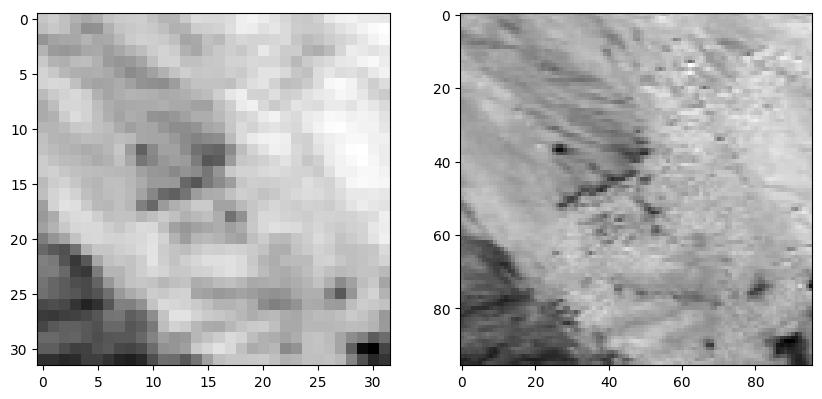

In [11]:
# print first patch and check if LR is in accordance with HR
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(X_train_patches[0,:,:,0], cmap = 'gray')
ax[1].imshow(y_train_patches[0,:,:,0], cmap = 'gray')

In [12]:
# free up memory
del X_train, y_train, y_train_mask

del X_val, y_val, y_val_mask

## 2.2 Clarity patches check

In [13]:
# find patches indices with a lower percentage of clean pixels in train array
patches_to_remove_train = [i for i,m in enumerate(y_train_mask_patches) if np.count_nonzero(m)/(HR_SIZE*HR_SIZE) < CLEAN_PATH_PX]

In [14]:
# find patches indices with a lower percentage of clean pixels in validation array
patches_to_remove_val = [i for i,m in enumerate(y_val_mask_patches) if np.count_nonzero(m)/(HR_SIZE*HR_SIZE) < CLEAN_PATH_PX]

In [15]:
# print number of patches to be removed
print(len(patches_to_remove_train))
print(len(patches_to_remove_val))

588
32


In [16]:
# remove patches not clean
X_train_patches = np.delete(X_train_patches,patches_to_remove_train,axis=0)
y_train_patches =  np.delete(y_train_patches,patches_to_remove_train,axis=0)
y_train_mask_patches =  np.delete(y_train_mask_patches,patches_to_remove_train,axis=0)

X_val_patches = np.delete(X_val_patches,patches_to_remove_val,axis=0)
y_val_patches =  np.delete(y_val_patches,patches_to_remove_val,axis=0)
y_val_mask_patches =  np.delete(y_val_mask_patches,patches_to_remove_val,axis=0)

<a id="network"></a>
# 3.0 Build the network

In [17]:
# build Super3D network
Super3D_network = Super3D(scale=SCALE, filters=FILTERS, 
                 kernel_size=KERNEL_SIZE, channels=CHANNELS, r=R, N=N)

In [18]:
# print architecture structure
Super3D_network.summary(line_length=120)

Model: "RAMS"
________________________________________________________________________________________________________________________
 Layer (type)                          Output Shape               Param #       Connected to                            
 input_1 (InputLayer)                  [(None, None, None, 9)]    0             []                                      
                                                                                                                        
 lambda (Lambda)                       (None, None, None, 9)      0             ['input_1[0][0]']                       
                                                                                                                        
 lambda_1 (Lambda)                     (None, None, None, 9, 1)   0             ['lambda[0][0]']                        
                                                                                                                        
 lambda_2 (Lambda)

<a id="train"></a>
# 4.0 Train the network

In [19]:
trainer_Super3D = Trainer(Super3D_network, band, HR_SIZE, name_net,
                      loss=l1_loss,
                      metric=psnr,
                      optimizer=tf.keras.optimizers.Nadam(learning_rate=lr),
                      checkpoint_dir=os.path.join(checkpoint_dir),
                      log_dir=log_dir)

In [20]:
trainer_Super3D.fit(X_train_patches,
                [y_train_patches.astype('float32'), y_train_mask_patches], initial_epoch = 0,
                batch_size=150, evaluate_every=400, data_aug = True, epochs=5,
                validation_data=(X_val_patches, [y_val_patches.astype('float32'), y_val_mask_patches])) 


Epoch 1/5


2024-12-15 18:59:02.246615: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4950/4900 [==============================] - 1620s 327ms/step - Loss: 686.4639 - PSNR: 37.7134 - Val Loss: 0.0000e+00 - Val PSNR: 0.0000e+00

Epoch 2/5
4950/4900 [==============================] - 1603s 324ms/step - Loss: 599.3494 - PSNR: 38.9981 - Val Loss: 0.0000e+00 - Val PSNR: 0.0000e+00

Epoch 3/5
4950/4900 [==============================] - 1606s 324ms/step - Loss: 525.5253 - PSNR: 40.1361 - Val Loss: 0.0000e+00 - Val PSNR: 0.0000e+00

Epoch 4/5
4950/4900 [==============================] - 1603s 324ms/step - Loss: 460.1693 - PSNR: 41.2506 - Val Loss: 0.0000e+00 - Val PSNR: 0.0000e+00

Epoch 5/5
4950/4900 [==============================] - 1598s 323ms/step - Loss: 458.9880 - PSNR: 41.2183 - Val Loss: 0.0000e+00 - Val PSNR: 0.0000e+00
